In [4]:
import argparse
import os
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd
from PIL import Image, ImageOps, ImageFilter

from dataloaders import make_data_loader
from modeling.sync_batchnorm.replicate import patch_replication_callback
from modeling.deeplab import *
from utils.loss import SegmentationLosses
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator
from dataloaders.utils_zzm import decode_segmap, decode_segmap_gray_apollo, encode_segmap

In [35]:
list = []
a = torch.from_numpy(np.array([1, 2, 3, 4]))
b = torch.from_numpy(np.array([2, 4, 6, 8]))
c = torch.from_numpy(np.array([3, 6, 9, 12]))
a = np.array([[1, 2, 3, 4]])
b = np.array([[2, 4, 6, 8]])
c = np.array([[3, 6, 9, 12]])
d = np.array([[4, 8, 12, 16]])
list.append(a)
list.append(b)
list.append(c)
list.append(d)
list

[array([[1, 2, 3, 4]]),
 array([[2, 4, 6, 8]]),
 array([[ 3,  6,  9, 12]]),
 array([[ 4,  8, 12, 16]])]

In [36]:
list_arr = np.array(list)
list_torch = torch.from_numpy(list_arr)
list_torch

tensor([[[ 1,  2,  3,  4]],

        [[ 2,  4,  6,  8]],

        [[ 3,  6,  9, 12]],

        [[ 4,  8, 12, 16]]])

In [37]:
list_torch.shape

torch.Size([4, 1, 4])

In [38]:
list_torch[:3]

tensor([[[ 1,  2,  3,  4]],

        [[ 2,  4,  6,  8]],

        [[ 3,  6,  9, 12]]])

#### makeargs

In [2]:
def makeargs():
    parser = argparse.ArgumentParser(description="PyTorch DeeplabV3Plus Training")
    parser.add_argument('--backbone', type=str, default='mobilenet',#########################此处改backbone
                        choices=['resnet', 'xception', 'drn', 'mobilenet'],
                        help='backbone name (default: resnet)')
    parser.add_argument('--output_stride', type=int, default=16,
                        help='network output stride (default: 8)')
    parser.add_argument('--dataset', type=str, default='apollo',
                        choices=['pascal', 'coco', 'cityscapes', 'apollo'],
                        help='dataset name (default: pascal)')
    # parser.add_argument('--use-sbd', action='store_true', default=False,
    #                     help='whether to use SBD dataset (default: True)')
    parser.add_argument('--workers', type=int, default=4,
                        metavar='N', help='dataloader threads')
    parser.add_argument('--base-size', type=int, default=513,
                        help='base image size')
    parser.add_argument('--crop-size', type=int, default=513,
                        help='crop image size')
    parser.add_argument('--sync-bn', type=bool, default=None,
                        help='whether to use sync bn (default: auto)')
    parser.add_argument('--freeze-bn', type=bool, default=False,
                        help='whether to freeze bn parameters (default: False)')
    parser.add_argument('--loss-type', type=str, default='ce',
                        choices=['ce', 'focal'],
                        help='loss func type (default: ce)')
    # training hyper params
    parser.add_argument('--epochs', type=int, default=None, metavar='N',
                        help='number of epochs to train (default: auto)')
    parser.add_argument('--start_epoch', type=int, default=0,
                        metavar='N', help='start epochs (default:0)')
    parser.add_argument('--batch-size', type=int, default=None,
                        metavar='N', help='input batch size for \
                                training (default: auto)')
    parser.add_argument('--test-batch-size', type=int, default=None,
                        metavar='N', help='input batch size for \
                                testing (default: auto)')
    parser.add_argument('--use-balanced-weights', action='store_true', default=False,
                        help='whether to use balanced weights (default: False)')
    # optimizer params
    parser.add_argument('--lr', type=float, default=None, metavar='LR',
                        help='learning rate (default: auto)')
    parser.add_argument('--lr-scheduler', type=str, default='poly',
                        choices=['poly', 'step', 'cos'],
                        help='lr scheduler mode: (default: poly)')
    parser.add_argument('--momentum', type=float, default=0.9,
                        metavar='M', help='momentum (default: 0.9)')
    parser.add_argument('--weight-decay', type=float, default=5e-4,
                        metavar='M', help='w-decay (default: 5e-4)')
    parser.add_argument('--nesterov', action='store_true', default=False,
                        help='whether use nesterov (default: False)')
    # cuda, seed and logging
    parser.add_argument('--no-cuda', action='store_true', default=
                        False, help='disables CUDA training')
    parser.add_argument('--gpu-ids', type=str, default='0',
                        help='use which gpu to train, must be a \
                        comma-separated list of integers only (default=0)')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    # checking point
    parser.add_argument('--resume', type=str, default=None,
                        help='put the path to resuming file if needed')
    parser.add_argument('--checkname', type=str, default=None,
                        help='set the checkpoint name')
    # finetuning pre-trained models
    parser.add_argument('--ft', action='store_true', default=False,
                        help='finetuning on a different dataset')
    # evaluation option
    parser.add_argument('--eval-interval', type=int, default=1,
                        help='evaluuation interval (default: 1)')
    parser.add_argument('--no-val', action='store_true', default=False,
                        help='skip validation during training')

    args = parser.parse_args([])
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    if args.cuda:
        try:
            args.gpu_ids = [int(s) for s in args.gpu_ids.split(',')]
        except ValueError:
            raise ValueError('Argument --gpu_ids must be a comma-separated list of integers only')

    if args.sync_bn is None:
        if args.cuda and len(args.gpu_ids) > 1:
            args.sync_bn = True
        else:
            args.sync_bn = False

    # default settings for epochs, batch_size and lr
    if args.epochs is None:
        epoches = {
            'coco': 30,
            'cityscapes': 200,
            'pascal': 50,
            'apollo':20
        }
        args.epochs = epoches[args.dataset.lower()]

    if args.batch_size is None:
        args.batch_size = 2 * len(args.gpu_ids)

    if args.test_batch_size is None:
        args.test_batch_size = 1

    if args.lr is None:
        lrs = {
            'coco': 0.1,
            'cityscapes': 0.01,
            'pascal': 0.007,
            'apollo': 0.01
        }
        args.lr = lrs[args.dataset.lower()] / (4 * len(args.gpu_ids)) * args.batch_size


    if args.checkname is None:
        args.checkname = 'deeplab-'+str(args.backbone)
    print(args)#打印参数信息
    return args

#### trainer

In [3]:
class Trainer(object):
    def __init__(self, args):
        self.args = args
        kwargs = {'num_workers': args.workers, 'pin_memory': True}
        self.train_loader, self.val_loader, self.test_loader, self.nclass = make_data_loader(args, **kwargs)
        
        model = DeepLab(num_classes=self.nclass, backbone=args.backbone, 
                       output_stride=args.output_stride, sync_bn=args.sync_bn,
                       freeze_bn=args.freeze_bn)
        train_params = [{'params': model.get_1x_lr_params(), 'lr': args.lr},
                        {'params': model.get_10x_lr_params(), 'lr': args.lr * 10}]
        optimizer = torch.optim.SGD(train_params, momentum=args.momentum,
                                    weight_decay=args.weight_decay, nesterov=args.nesterov)
        self.criterion = SegmentationLosses(weight=None, cuda=args.cuda).build_loss(mode=args.loss_type)
        self.model, self.optimizer = model, optimizer
        self.evaluator = Evaluator(self.nclass)
        self.scheduler = LR_Scheduler(args.lr_scheduler, args.lr, args.epochs, len(self.train_loader))
        
        self.model = model.cuda()
        
        self.best_pred = 0.0
        if args.resume is not None:
            if not os.path.isfile(args.resume):
                raise RuntimeError("=> no checkpoint found at '{}'" .format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            if args.cuda:
                self.model.module.load_state_dict(checkpoint['state_dict'])
            else:
                self.model.load_state_dict(checkpoint['state_dict'])
            if not args.ft:
                self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.best_pred = checkpoint['best_pred']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.resume, checkpoint['epoch']))
        
        if args.ft:
            args.start_epoch = 0
    
    def training(self, epoch):
        train_loss = 0.0
        self.model.train()
        tbar = tqdm(self.train_loader)
        num_img_tr = len(self.train_loader)
        for i, sample in enumerate(tbar):
            image, target = sample['image'], sample['label']
            image, target = image.cuda(), target.cuda()
            self.scheduler(self.optimizer, i, epoch, self.best_pred)
            self.optimizer.zero_grad()
            output = self.model(image)
            loss = self.criterion(output, target)
            loss.backward()
            self.optimizer.step()
            train_loss += loss.item()
            tbar.set_description('Train loss: %.3f' %(train_loss / (i+1)))
            
        print('[Epoch: %d, numImages: %5d]' % (epoch, i * self.args.batch_size + image.data.shape[0]))
        print('Loss: %.3f' % train_loss)
        
    def validation(self, epoch):
        self.model.eval()
        self.evaluator.reset()
        tbar = tqdm(self.val_loader, desc='\r')
        test_loss = 0.0
        for i, sample in enumerate(tbar):
            image, target = sample['image'], sample['label']
            image, target = image.cuda(), target.cuda()
            with torch.no_grad(): #
                output = self.model(image)
            loss = self.criterion(output, target)
            test_loss += loss.item()
            tbar.set_description('Test loss: %.3f' % (test_loss / (i + 1)))
            pred = output.data.cpu().numpy()
            target = target.cpu().numpy()
            pred = np.argmax(pred, axis=1)
            self.evaluator.add_batch(target, pred)
            
            
        Acc = self.evaluator.Pixel_Accuracy()
        mIoU = self.evaluator.Mean_Intersection_over_Union()
        print('Validation:')
        print('[Epoch: %d, numImages: %5d]' % (epoch, i * self.args.batch_size + image.data.shape[0]))
        print("Acc:{}, mIoU:{},".format(Acc, mIoU))
        print('Loss: %.3f' % test_loss)

#### test

In [3]:
def test(model_path):
    args = makeargs()
    kwargs = {'num_workers': args.workers, 'pin_memory': True}
    train_loader, val_loader, test_loader, nclass = make_data_loader(args, **kwargs)
    data = pd.read_csv(os.path.join(os.getcwd(), "data_list", "test_lite.csv"), header=None, names=["image","label"])
    images = data["image"].values[1:]
    print('Loading model...')
    model = DeepLab(num_classes=8,backbone='mobilenet',output_stride=args.output_stride,
                   sync_bn=args.sync_bn,freeze_bn=args.freeze_bn)
    model.eval()
    checkpoint = torch.load(model_path)
    model = model.cuda()
    model.load_state_dict(checkpoint['state_dict'])
    print('Done')
    criterion = SegmentationLosses(weight=None, cuda=args.cuda).build_loss(mode=args.loss_type)
    evaluator = Evaluator(nclass)
    evaluator.reset()
    
    print('Model infering')
    test_dir = 'test_example'
#     tbar = tqdm(test_loader, desc='\r')
    test_loss = 0.0
    for i, sample in enumerate(test_loader):
        image, target = sample['image'], sample['label']
        image, target = image.cuda(), target.cuda()
        
        with torch.no_grad(): #
            output = model(image)
        loss = criterion(output, target)
        test_loss += loss.item()
#         tbar.set_description('Test loss: %.3f' % (test_loss / (i + 1)))
        pred = output.data.cpu().numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        evaluator.add_batch(target, pred)
        
        #decode 
        pred = np.squeeze(pred)
        color_mask = decode_segmap(pred, dataset='apollo')
#         color_mask = np.transpose(pred, (1, 2, 0))
        cv2.imwrite(os.path.join(test_dir,'%dcolor_mask.jpg'%i), color_mask)
            
    print(image.shape)
    print(color_mask.shape)
    Acc = evaluator.Pixel_Accuracy()
    mIoU = evaluator.Mean_Intersection_over_Union()
    print('testing:')
    print("Acc:{}, mIoU:{},".format(Acc, mIoU))
    print('Loss: %.3f' % test_loss)
    
    
    
    

In [ ]:
test(model_path)

#### unzip test

In [3]:
model_path = 'run/apollo/deeplab-mobilenet/size1_69epoch/checkpoint.pth.tar'

In [7]:
args = makeargs()
kwargs = {'num_workers': args.workers, 'pin_memory': True}
train_loader, val_loader, test_loader, nclass = make_data_loader(args, **kwargs)
data = pd.read_csv(os.path.join(os.getcwd(), "data_list", "test_lite.csv"), header=None, names=["image","label"])
images = data["image"].values[1:]
print('Loading model...')
model = DeepLab(num_classes=8,backbone='mobilenet',output_stride=args.output_stride,#########改backbone
               sync_bn=args.sync_bn,freeze_bn=args.freeze_bn)
model.eval()
checkpoint = torch.load(model_path)
model = model.cuda()
model.load_state_dict(checkpoint['state_dict'])
print('Done')
criterion = SegmentationLosses(weight=None, cuda=args.cuda).build_loss(mode=args.loss_type)
evaluator = Evaluator(nclass)
evaluator.reset()

print('Model infering')
test_dir = 'test_example'
tbar = tqdm(test_loader, desc='\r')
test_loss = 0.0
for i, sample in enumerate(tbar):
    image, target = sample['image'], sample['label']
    image, target = image.cuda(), target.cuda()

    with torch.no_grad(): #
        output = model(image)
    loss = criterion(output, target)
    test_loss += loss.item()
#         tbar.set_description('Test loss: %.3f' % (test_loss / (i + 1)))
    pred = output.data.cpu().numpy()
    target = target.cpu().numpy()
    pred = np.argmax(pred, axis=1)
    evaluator.add_batch(target, pred)

    #decode 
    pred = np.squeeze(pred)
    color_mask = decode_segmap(pred, dataset='apollo')
#         color_mask = np.transpose(pred, (1, 2, 0))
    cv2.imwrite(os.path.join(test_dir,'%dcolor_mask.jpg'%i), color_mask)

print(image.shape)
print(color_mask.shape)
Acc = evaluator.Pixel_Accuracy()
mIoU = evaluator.Mean_Intersection_over_Union()
print('testing:')
print("Acc:{}, mIoU:{},".format(Acc, mIoU))
print(mIoU)
print('Loss: %.3f' % test_loss)


Namespace(backbone='mobilenet', base_size=513, batch_size=2, checkname='deeplab-mobilenet', crop_size=513, cuda=True, dataset='apollo', epochs=20, eval_interval=1, freeze_bn=False, ft=False, gpu_ids=[0], loss_type='ce', lr=0.005, lr_scheduler='poly', momentum=0.9, nesterov=False, no_cuda=False, no_val=False, output_stride=16, resume=None, seed=1, start_epoch=0, sync_bn=False, test_batch_size=1, use_balanced_weights=False, weight_decay=0.0005, workers=4)
Loading model...



:   0%|          | 0/1326 [00:00<?, ?it/s]

Done
Model infering



:  22%|██▏       | 294/1326 [00:58<04:32,  3.78it/s]


:  44%|████▍     | 586/1326 [02:07<02:55,  4.21it/s]


:  66%|██████▌   | 878/1326 [03:15<01:48,  4.12it/s]


:  88%|████████▊ | 1166/1326 [04:24<00:34,  4.68it/s]


: 100%|██████████| 1326/1326 [04:58<00:00,  4.45it/s]

torch.Size([1, 3, 512, 1536])
(512, 1536, 3)
testing:
Acc:0.9947535714772312, mIoU:[0.99469656 0.87070085 0.8184866  0.72155816 0.67573724 0.8461473
 0.83436845 0.77970864],
[0.99469656 0.87070085 0.8184866  0.72155816 0.67573724 0.8461473
 0.83436845 0.77970864]
Loss: 19.993


In [ ]:
image.shape

In [12]:
miou = np.mean(np.array([0.99469656,0.87070085,0.8184866,0.72155816,0.67573724,0.8461473,0.83436845,0.77970864]))
miou

0.8176754749999999

#### 可视化

In [15]:
import matplotlib.pyplot as plt

In [ ]:
img_show = np.transpose(torch.squeeze(image).cpu().numpy(),(1,2,0))
img_show.shape

In [ ]:
img_show = cv2.imread('/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road04/Record009/Camera 5/171206_055333015_Camera_5.jpg')
b,g,r = cv2.split(img_show)
img_show = cv2.merge([r,g,b])

In [ ]:
plt.imshow(img_show)

#### decode function

In [4]:
#该文件主要作用是对数据集进行编解码
import matplotlib.pyplot as plt
import numpy as np
import torch

def decode_seg_map_sequence(label_masks, dataset='pascal'):
    rgb_masks = []
    for label_mask in label_masks:
        rgb_mask = decode_segmap(label_mask, dataset)
        rgb_masks.append(rgb_mask)
    rgb_masks = torch.from_numpy(np.array(rgb_masks).transpose([0, 3, 1, 2]))#tensor形式的颜色图标记
    return rgb_masks


def get_cityscapes_labels():
    return np.asarray([[[128, 64, 128]], [[244, 35, 232]], [[70, 70, 70]],
                      [[102, 102, 156]], [[190, 153, 153]], [[153, 153, 153]],
                      [[250, 170, 30]], [[220, 220, 0]], [[107, 142, 35]], 
                      [[152, 251, 152]], [[0, 130, 180]], [[220, 20, 60]],
                      [[255, 0, 0]], [[0, 0, 142]], [[0, 0, 70]], [[0, 60, 100]],
                      [[0, 80, 100]], [[0, 0, 230]], [[119, 11, 32]]])

def get_pascal_labels():
    """Load the mapping that associates pascal classes with label colors
    Returns:
        np.ndarray with dimensions (21, 3)
    """
    # return np.asarray([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
    #                    [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    #                    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
    #                    [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    #                    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    #                    [0, 64, 128]])
    return np.asarray([[[0, 0, 0]], [[128, 0, 0]], [[0, 128, 0]], [[128, 128, 0]],
            [[0, 0, 128]], [[128, 0, 128]], [[0, 128, 128]], [[128, 128, 128]],
            [[64, 0, 0]], [[192, 0, 0]], [[64, 128, 0]], [[192, 128, 0]],
            [[64, 0, 128]], [[192, 0, 128]], [[64, 128, 128]], [[192, 128, 128]],
            [[0, 64, 0]], [[128, 64, 0]], [[0, 192, 0]], [[128, 192, 0]],
            [[0, 64, 128]]])

def get_apollo_color_labels():
    return np.asarray([[[0, 0, 0], [0, 153, 153], [255, 255, 255],[128, 0, 128], [0, 0, 60], [0, 60, 100], [244, 35, 232], [0, 0, 160],[153, 153, 153], [250, 170, 30],[102, 102, 156], [128, 0, 0], [238, 232, 170],[0, 0, 230], [255, 165, 0], [0, 191, 255], [51, 255, 51], [250, 128, 114], [127, 255, 0], [0, 255, 255], [128, 128, 64]], #0
                       [[70, 130, 180], [220, 20, 60],[255, 0, 0]], #1
                       [[0, 0, 142], [119, 11, 32]],#2
                       [[220, 220, 0]],#3
                       [[128, 64, 128]],#4
                       [[190, 153, 153]],#5
                       [[128, 128, 0], [128, 78, 160], [150, 100, 100], [180, 165, 180], [107, 142, 35], [201, 255, 229]],#6
                       [[255, 128, 0], [178, 132, 190], [102, 0, 204]]#7
                       ])

def get_apollo_gray_labels():
    return np.asarray([[0, 249, 255, 213, 206, 207, 211, 208, 216, 215,218, 219,232, 202, 231, 230, 228, 229, 233, 212, 223],
                       [200, 204, 209], 
                       [201,203], 
                       [217], 
                       [210], 
                       [214],
                       [220,221,222,224,225,226],
                       [205,227,250]])

def encode_segmap(mask):#颜色图转类别标签
    mask = mask.astype(int)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for ii, _label in enumerate(get_apollo_color_labels()):
        for label in _label:
            label_mask[np.where(np.all(mask == label, axis=-1))[:2]] = ii
    label_mask = label_mask.astype(int)
    return label_mask

def decode_segmap(label_mask, dataset, plot=False):#类别标签转颜色图标记
    if dataset == 'pascal' or dataset == 'coco':
        n_classes = 21
        label_colours = get_pascal_labels()
    elif dataset == 'cityscapes':
        n_classes = 19
        label_colours = get_cityscapes_labels()
    elif dataset == 'apollo':
        n_classes = 8
        label_colours = get_apollo_color_labels()
    else:
        raise NotImplementedError

    r = label_mask.copy()
    g = label_mask.copy()
    b = label_mask.copy()
    for ll in range(0, n_classes):
        r[label_mask == ll] = label_colours[ll][0][0]
        g[label_mask == ll] = label_colours[ll][0][1]
        b[label_mask == ll] = label_colours[ll][0][2]
    rgb = np.zeros((label_mask.shape[0], label_mask.shape[1], 3))
    rgb[:, :, 0] = r / 255.0
    rgb[:, :, 1] = g / 255.0
    rgb[:, :, 2] = b / 255.0
    if plot:
        plt.imshow(rgb)
        plt.show()
        return rgb
    else:
        return rgb

def encode_segmap_gray_apollo(mask):
    mask = mask.astype(np.int16)
    label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=np.int16)
    for ii , _label in enumerate(get_apollo_gray_labels()):
        for label in _label:
            label_mask[mask == label] = ii
    label_mask = label_mask.astype(np.int16)
    return label_mask

def decode_segmap_gray_apollo(label_mask, plot = False):
    n_classes = 8
    label_gray = get_apollo_gray_labels()
    gray = np.zeros((label_mask.shape[0], label_mask.shape[1]))
    for ll in range(0, n_classes):
        gray[label_mask == ll] = label_gray[ll][0]
    if plot:
        plt.subplot(1,2,2)
        plt.imshow(gray)
        plt.show()
    else:
        return gray


#### continue

In [ ]:
gray_mask = decode_segmap_gray_apollo(pred)
# gray_mask = np.array(gray_mask, dtype=np.uint8)
plt.imshow(gray_mask)

In [ ]:
color_label = decode_segmap(pred, 'apollo', plot=True)

In [ ]:
color_label.sum()

In [ ]:
def expand_resize_color_data(prediction=None, submission_size=[3384, 1710], offset=690):
    color_pred_mask = decode_color_labels(prediction)
    color_pred_mask = np.transpose(color_pred_mask, (1, 2, 0))
    color_expand_mask = cv2.resize(color_pred_mask, (submission_size[0], submission_size[1] - offset), interpolation=cv2.INTER_NEAREST)
    color_submission_mask = np.zeros((submission_size[1], submission_size[0], 3), dtype='uint8')
    color_submission_mask[offset:, :, :] = color_expand_mask
    return color_submission_mask

#### 解构inference过程

In [5]:
from dataloaders import custom_transforms as tr
from torchvision import transforms

In [6]:
IMAGE_SIZE = [(1024,384), (1536,512), (3384,1710)]
def crop_resize_data(image, label=None, image_size=IMAGE_SIZE[1], offset=690):
    """
    Attention:
    h,w, c = image.shape
    cv2.resize(image,(w,h))
    """
    roi_image = image[offset:, :]
    if label is not None:
        roi_label = label[offset:, :]
        train_image = cv2.resize(roi_image, image_size, interpolation=cv2.INTER_LINEAR)
        train_label = cv2.resize(roi_label, image_size, interpolation=cv2.INTER_NEAREST)
        return train_image, train_label
    else:
        train_image = cv2.resize(roi_image, image_size, interpolation=cv2.INTER_LINEAR)
        return train_image

In [7]:
def transform(sample, cropsize=IMAGE_SIZE[1], offset=690):
    roi_image = sample['image'].crop((0,offset,3384,1710))
    roi_label = sample['label'].crop((0,offset,3384,1710))
    sample['image'] = roi_image.resize(cropsize, Image.BILINEAR)
    sample['label'] = roi_label.resize(cropsize, Image.NEAREST)
    composed_transform  = transforms.Compose([
#         tr.RandomHorizontalFlip(),
#         tr.RandomGaussianBlur(),
        tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        tr.ToTensor()])
    return composed_transform(sample)

In [8]:
def load_model(model_path):
    args = makeargs()
    print('Loading model...')
    model = DeepLab(num_classes=8,backbone='drn',output_stride=args.output_stride,#改backbone
                   sync_bn=args.sync_bn,freeze_bn=args.freeze_bn)
    model.eval()
    checkpoint = torch.load(model_path)
    model = model.cuda()
    model.load_state_dict(checkpoint['state_dict'])
    print('model loaded')
    return model

In [10]:
def main():
    test_dir = pd.read_csv("data_list/test_lite.csv")
    test_dir = test_dir["image"]
    model_path = 'run/apollo/deeplab-drn/experiment_5/checkpoint.pth.tar'
    model = load_model(model_path)
    for i in range(0, len(test_dir)):
        image = cv2.imread(test_dir[i])
        target = cv2.imread(test_dir_lb[i])
        _img = Image.fromarray(image)
        _target = Image.fromarray(target)
        sample = {'image':_img, 'label':_target}
        _img, _target = transform(sample)['image'], transform(sample)['label']
    pred = model(_img)

In [11]:
Test_dir = pd.read_csv("data_list/test_lite.csv")
test_dir = Test_dir["image"].values
test_dir_lb = Test_dir["label"].values
test_dir

array(['/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road02/Record016/Camera 6/170927_065828444_Camera_6.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road04/Record009/Camera 6/171206_055349746_Camera_6.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road04/Record009/Camera 6/171206_055317559_Camera_6.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road04/Record009/Camera 6/171206_055352203_Camera_6.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road04/Record005/Camera 6/171206_054722653_Camera_6.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road02/Record001/Camera 6/170927_063834576_Camera_6.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road04/Record002/Camera 5/171206_054320965_Camera_5.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road02/Record006/Camera 5/170927_064501266_Camera_5.jpg',
       '/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_D

In [15]:
model_path = 'run/apollo/deeplab-drn/experiment_5/checkpoint.pth.tar'
model = load_model(model_path)
sub_dir = './test_example/'
print("start inference...")
for i in range(0, len(test_dir)):
    image = cv2.imread(test_dir[i])
    target = cv2.imread(test_dir_lb[i])
    _img = Image.fromarray(image)
    _target = Image.fromarray(target)
    sample = {'image':_img, 'label':_target}
    _img, _target = transform(sample)['image'], transform(sample)['label']
    _img = _img.unsqueeze(dim=0)
    _img = _img.cuda()
    
    with torch.no_grad():
        pred = model(_img)
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    pred = torch.squeeze(pred)
    pred = pred.detach().cpu().numpy()
#     pred = decode_segmap_gray_apollo(pred)
    print("inference done %d of %d"%(i, len(test_dir)))
    prediction = expand_resize_data(pred)
    color_labels = decode_color_labels(prediction)
    color_labels = np.transpose(color_labels, (1, 2, 0))
    img_ori = cv2.imread(test_dir[i])
#     img_ori = cv2.cvtColor(cv2.imread(test_dir[i]), cv2.COLOR_BGR2RGB)
    added = cv2.addWeighted(img_ori, 1, color_labels, 0.3, 0)
    cv2.imwrite(os.path.join(sub_dir, test_dir[i][-29:]), added)

Namespace(backbone='drn', base_size=513, batch_size=2, checkname='deeplab-drn', crop_size=513, cuda=True, dataset='apollo', epochs=20, eval_interval=1, freeze_bn=False, ft=False, gpu_ids=[0], loss_type='ce', lr=0.005, lr_scheduler='poly', momentum=0.9, nesterov=False, no_cuda=False, no_val=False, output_stride=16, resume=None, seed=1, start_epoch=0, sync_bn=False, test_batch_size=1, use_balanced_weights=False, weight_decay=0.0005, workers=4)
Loading model...
model loaded
start inference...
inference done 0 of 795
inference done 1 of 795
inference done 2 of 795
inference done 3 of 795
inference done 4 of 795
inference done 5 of 795
inference done 6 of 795
inference done 7 of 795
inference done 8 of 795
inference done 9 of 795
inference done 10 of 795
inference done 11 of 795
inference done 12 of 795
inference done 13 of 795
inference done 14 of 795
inference done 15 of 795
inference done 16 of 795
inference done 17 of 795
inference done 18 of 795
inference done 19 of 795
inference done 

inference done 301 of 795
inference done 302 of 795
inference done 303 of 795
inference done 304 of 795
inference done 305 of 795
inference done 306 of 795
inference done 307 of 795
inference done 308 of 795
inference done 309 of 795
inference done 310 of 795
inference done 311 of 795
inference done 312 of 795
inference done 313 of 795
inference done 314 of 795
inference done 315 of 795
inference done 316 of 795
inference done 317 of 795
inference done 318 of 795
inference done 319 of 795
inference done 320 of 795
inference done 321 of 795
inference done 322 of 795
inference done 323 of 795
inference done 324 of 795
inference done 325 of 795
inference done 326 of 795
inference done 327 of 795
inference done 328 of 795
inference done 329 of 795
inference done 330 of 795
inference done 331 of 795
inference done 332 of 795
inference done 333 of 795
inference done 334 of 795
inference done 335 of 795
inference done 336 of 795
inference done 337 of 795
inference done 338 of 795
inference do

inference done 617 of 795
inference done 618 of 795
inference done 619 of 795
inference done 620 of 795
inference done 621 of 795
inference done 622 of 795
inference done 623 of 795
inference done 624 of 795
inference done 625 of 795
inference done 626 of 795
inference done 627 of 795
inference done 628 of 795
inference done 629 of 795
inference done 630 of 795
inference done 631 of 795
inference done 632 of 795
inference done 633 of 795
inference done 634 of 795
inference done 635 of 795
inference done 636 of 795
inference done 637 of 795
inference done 638 of 795
inference done 639 of 795
inference done 640 of 795
inference done 641 of 795
inference done 642 of 795
inference done 643 of 795
inference done 644 of 795
inference done 645 of 795
inference done 646 of 795
inference done 647 of 795
inference done 648 of 795
inference done 649 of 795
inference done 650 of 795
inference done 651 of 795
inference done 652 of 795
inference done 653 of 795
inference done 654 of 795
inference do

In [156]:
pred.shape

(384, 1024)

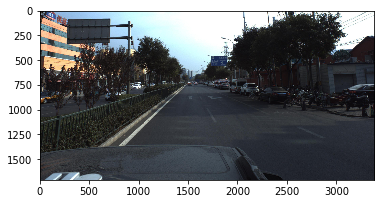

In [62]:
img_ori = Image.open('/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road02/Record016/Camera 6/170927_065828444_Camera_6.jpg')
img_ori = np.array(img_ori)
plt.imshow(img_ori)

In [57]:
img_ori.shape

(1710, 3384, 3)

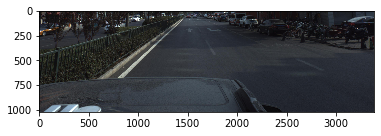

In [69]:
im = Image.open('/media/aaron/本地磁盘/dataset/BaiduLane_lite/Image_Data/Road02/Record016/Camera 6/170927_065828444_Camera_6.jpg')
box = (0, 690, 3384, 1710)              ##确定拷贝区域大小
region = im.crop(box)                ##将im表示的图片对象拷贝到region中，大小为box
region = np.array(region)
plt.imshow(region)

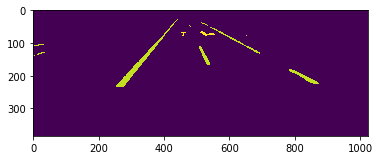

In [161]:
plt.imshow(decode_segmap_gray_apollo(pred))

In [103]:
decode_segmap(pred,dataset='apollo')

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [99]:
decode_segmap_gray_apollo(pred).sum()

1193287.0

In [14]:
def decode_color_labels(labels):
    decode_mask = np.zeros((3, labels.shape[0], labels.shape[1]), dtype='uint8')
    # 0
    decode_mask[0][labels == 0] = 0
    decode_mask[1][labels == 0] = 0
    decode_mask[2][labels == 0] = 0
    # 1
    decode_mask[0][labels == 1] = 70
    decode_mask[1][labels == 1] = 130
    decode_mask[2][labels == 1] = 180
    # 2
    decode_mask[0][labels == 2] = 0
    decode_mask[1][labels == 2] = 0
    decode_mask[2][labels == 2] = 142
    # 3
    decode_mask[0][labels == 3] = 153
    decode_mask[1][labels == 3] = 153
    decode_mask[2][labels == 3] = 153
    # 4
    decode_mask[0][labels == 4] = 128
    decode_mask[1][labels == 4] = 64
    decode_mask[2][labels == 4] = 128
    # 5
    decode_mask[0][labels == 5] = 190
    decode_mask[1][labels == 5] = 153
    decode_mask[2][labels == 5] = 153
    # 6
    decode_mask[0][labels == 6] = 0
    decode_mask[1][labels == 6] = 0
    decode_mask[2][labels == 6] = 230
    # 7
    decode_mask[0][labels == 7] = 255
    decode_mask[1][labels == 7] = 128
    decode_mask[2][labels == 7] = 0

    return decode_mask


In [13]:
def expand_resize_data(prediction=None, submission_size=[3384, 1710], offset=690):
    expand_mask = cv2.resize(prediction, (submission_size[0], submission_size[1] - offset), interpolation=cv2.INTER_NEAREST)
    submission_mask = np.zeros((submission_size[1], submission_size[0]), dtype='uint8')
    submission_mask[offset:, :] = expand_mask
    return submission_mask

In [164]:
prediction = expand_resize_data(pred)
color_labels = decode_color_labels(prediction)
color_labels = np.transpose(color_labels, (1, 2, 0))

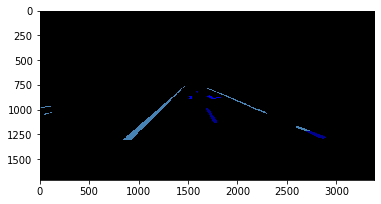

In [165]:
plt.imshow(color_labels)

#### todo:检查decode_segmap的可用性完成expandresize , make submissions

In [142]:
test_dir[0][-29:]

'170927_065828444_Camera_6.jpg'

In [144]:
sub_dir = './test_example/'

In [149]:
added = cv2.addWeighted(img_ori, 0.7, color_labels, 0.3, 0)

In [151]:
cv2.imwrite(os.path.join(sub_dir, test_dir[0][-29:]), added)

True

In [198]:
imgori = cv2.cvtColor(cv2.imread(test_dir[i]), cv2.COLOR_BGR2RGB)

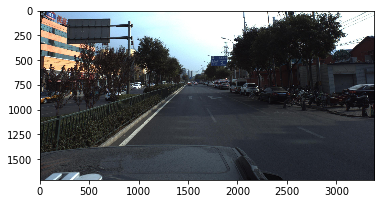

In [192]:
plt.imshow(imgori)

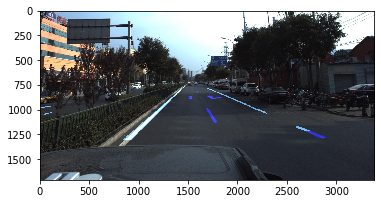

In [194]:
plt.imshow(cv2.addWeighted(imgori, 1, color_labels, 1, 0))

In [ ]:
args.resume = './run/apollo/deeplab-mobilenet/model_best.pth (0.79v100).tar'

In [201]:
directory = os.path.join('run', 'apollo', 'deeplab-mobilenet')
directory

'run/apollo/deeplab-mobilenet'

In [204]:
import glob

In [207]:
runs = sorted(glob.glob(os.path.join(directory, 'experiment_*')))
runs

['run/apollo/deeplab-mobilenet/experiment_1',
 'run/apollo/deeplab-mobilenet/experiment_2']

In [209]:
run_id = int(runs[-1].split('_')[-1]) + 1 
run_id

3

In [19]:
atrous = [1,2,1]

In [20]:
[atrous]*3

[[1, 2, 1], [1, 2, 1], [1, 2, 1]]

In [17]:
def Mean_Intersection_over_Union(self):
    MIoU = np.diag(self.confusion_matrix) / (
                np.sum(self.confusion_matrix, axis=1) + np.sum(self.confusion_matrix, axis=0) -
                np.diag(self.confusion_matrix))
    MIoU = np.nanmean(MIoU)
    return MIoU

In [19]:
cf_mt = np.array([[5,1,2],[0,6,2],[3,0,5]])
cf_mt

array([[5, 1, 2],
       [0, 6, 2],
       [3, 0, 5]])

In [20]:
np.diag(cf_mt)

array([5, 6, 5])

In [21]:
np.sum(cf_mt, axis=1)

array([8, 8, 8])

In [22]:
np.sum(cf_mt, axis=0)

array([8, 7, 9])

In [23]:
np.sum(cf_mt, axis=1)+np.sum(cf_mt, axis=0)-np.diag(cf_mt)

array([11,  9, 12])

In [25]:
miou=np.diag(cf_mt)/(np.sum(cf_mt, axis=1)+np.sum(cf_mt, axis=0)-np.diag(cf_mt))
miou

array([0.45454545, 0.66666667, 0.41666667])

In [ ]:
miou = np.nanmean(miou)
miou